In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

## Загрузка данных

In [9]:
train = pd.read_csv('../../sf_data/train.csv')
test = pd.read_csv('../../sf_data/test.csv')
train['label'] = 'train'
test['label'] = 'test'
data = pd.concat([train,test])


Проверка на нулевые значения. 

In [10]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
label                   0
dtype: int64

Определяем списки с типами признаков

In [11]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport','good_work']
cat_cols = ['education','region_rating', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']

Всякую работу с датами я оставил, хотя в первоначальной версии ноутбука был день недели. Просто знайте, что в этот ноутбук много чего не попало, поскольку сдаётся он уже после дедлайна

Далее, удаляем пропуск в данных по образованию. Самое логичное заменить эти пропуски модой.

In [12]:
mode = data.education.mode()[0]
data['education'].fillna(mode, inplace=True)


Логорифмируем все номинальные признаки кроме score_bki, поскольку этот признак и без того распределён нормально и к тому же имеет отрицательные значения.

In [13]:
data['age'] = np.log(data['age'] + 1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['income'] = np.log(data['income'] + 1)
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)


Проверяем по матрице корреляций, какие признаки линейно зависимы. 

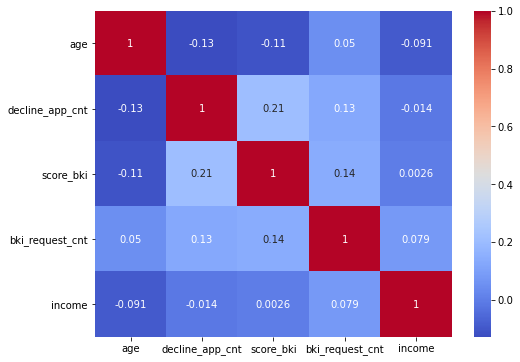

In [14]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data.loc[:,num_cols].corr(),annot = True, cmap = 'coolwarm')

Проверяем значимость признаков. Логично, что score_bki является самым значимым, поскольку в нём уже заложена информация о риске дефолта, возможно в нём даже заложена информация о том, был у клиента дефолт или нет.

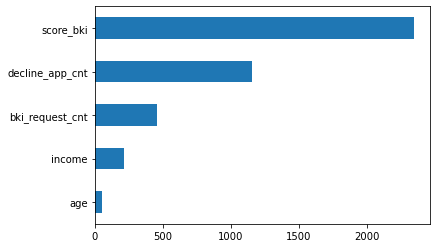

In [15]:
imp_num = pd.Series(f_classif(data[data.label == 'train'][num_cols], data[data.label == 'train']['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## Анализ категориальных признаков
Смотрим на боксплоты распределения числовых признаков относительно категориальных и бинарных.

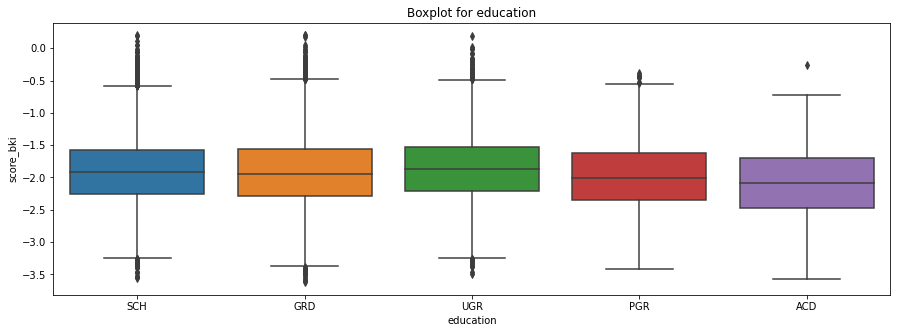

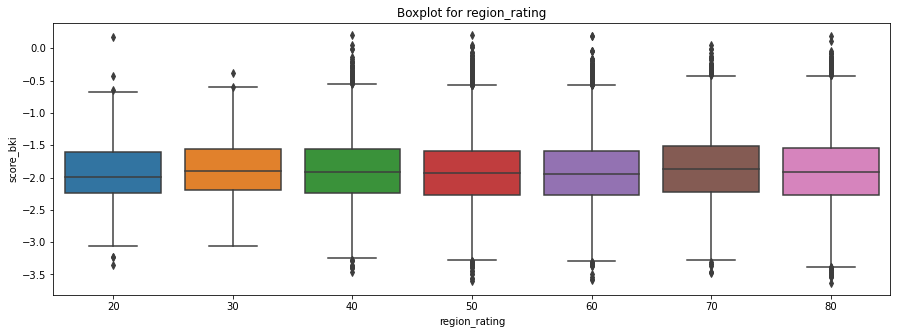

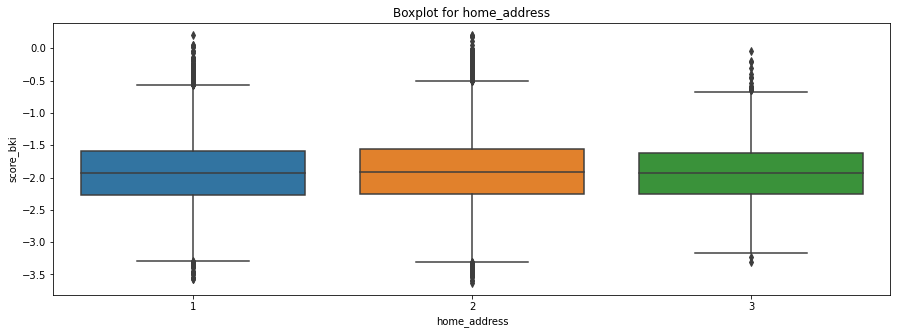

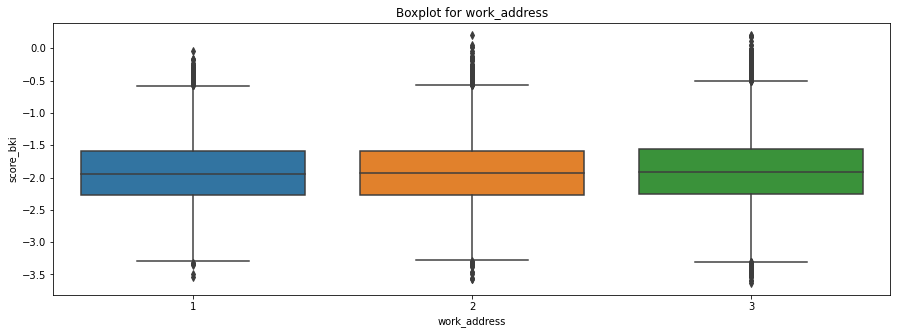

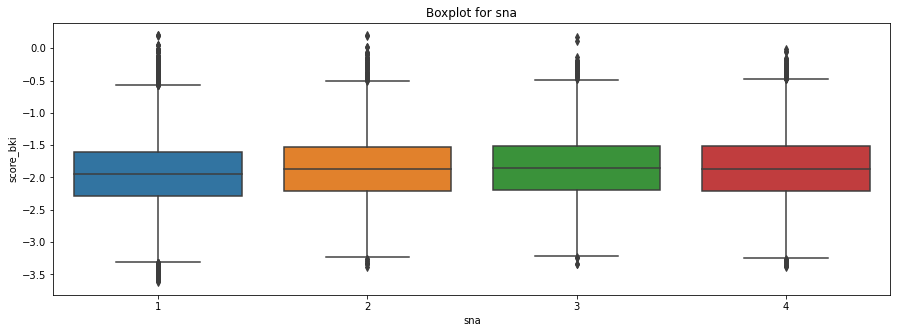

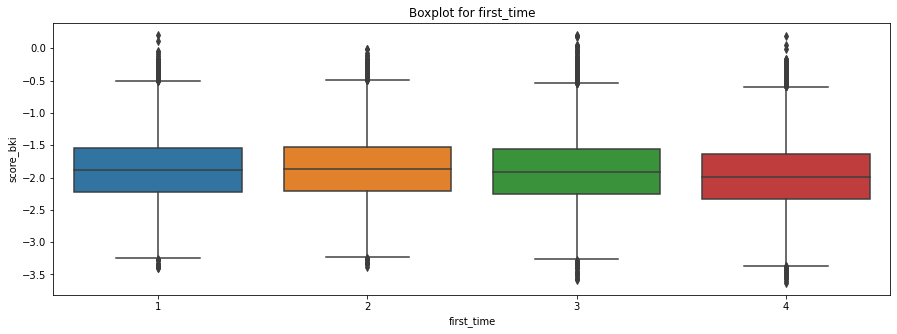

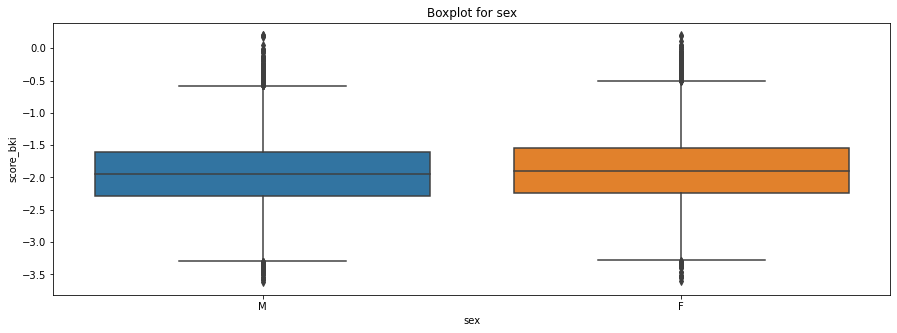

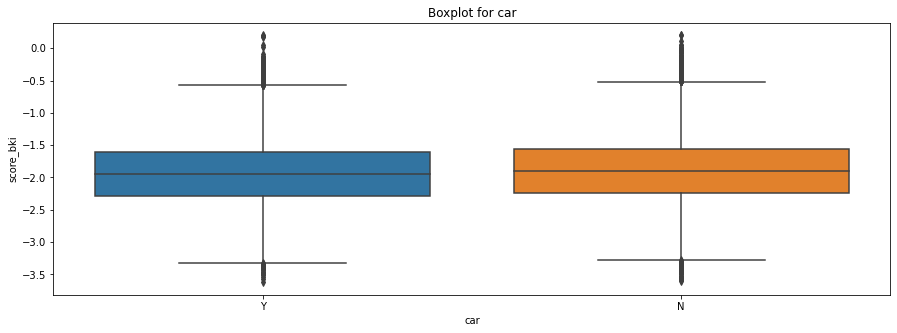

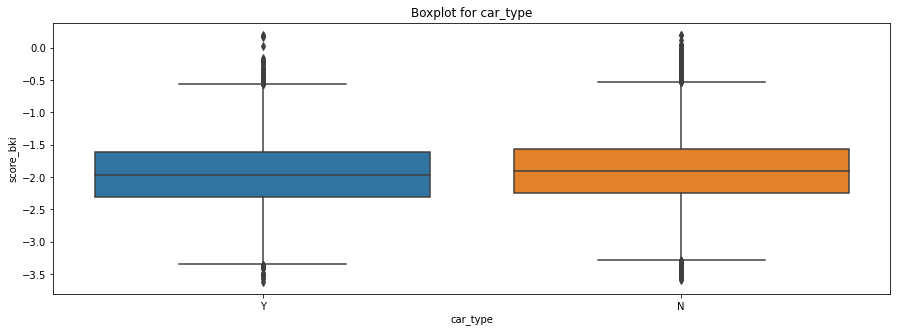

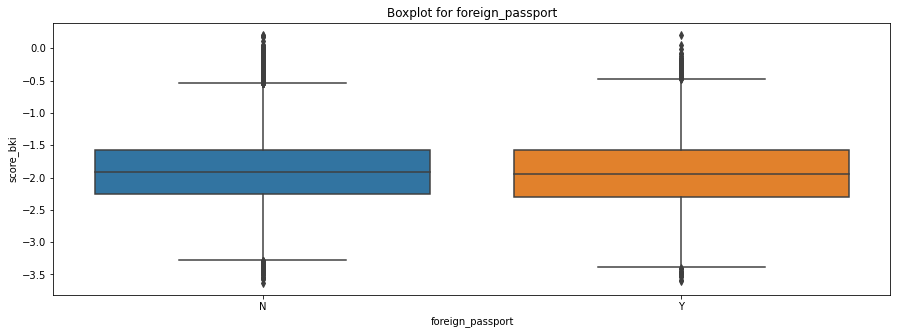

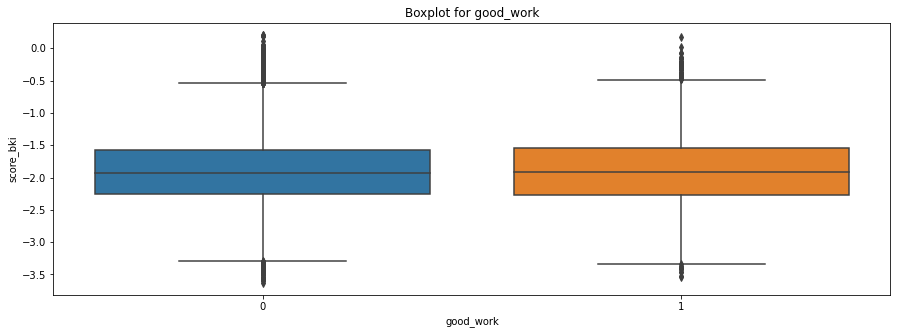

In [16]:
for col in cat_cols + bin_cols:
    fig, ax = plt.subplots(1, 1, figsize = (15, 5))
    sns.boxplot(x = col, y='score_bki', data = data, ax=ax)
    ax.set_title('Boxplot for {0}'.format(col))
    plt.show()

## Кодируем категориальные признаки
Образование и рейтинг региона имеют порядок, поэтому мы их кодируем, а не заменяем на дамми переменные

In [17]:
data['region_rating'] = LabelEncoder().fit_transform(data['region_rating'])
data['education'] = LabelEncoder().fit_transform(data['education'])


## Кодируем бинарные признаки

In [18]:
for col in bin_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

## Смотрим на значимость категориальных и бинарных признаков
Значимость минимальна

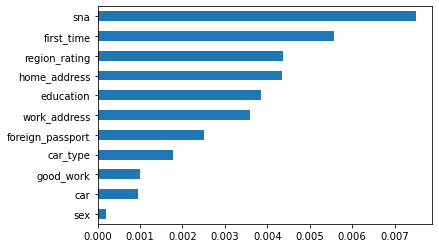

In [19]:
imp_cat = pd.Series(mutual_info_classif(data[data.label == 'train'][bin_cols + cat_cols], data[data.label == 'train']['default'], 
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Преобразовываем категоримальные признаки в дамми переменные, а числовые стандартизируем для лучшей работы алгоритма

In [20]:
data_cat = pd.get_dummies(data.loc[:, cat_cols], columns = cat_cols)
data_num = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = num_cols)

## Конкатенация полученных данных
Пришлось все столбцы превращать в датафрейм, а потом удалить повторяющуюся колонку index. По-другому сконкатенировать у меня не вышло

In [21]:
X = pd.concat([data_num.reset_index(), data_cat.reset_index(), data[bin_cols].reset_index(), data['label'].reset_index(), data['default'].reset_index()], axis = 1)
y = data['default'].values
X.drop('index',axis=1,inplace=True)



Отделяем тестовые данные и тренировочные

In [22]:
train_data = X[X.label=='train'].drop(['label'], axis=1)
test_data = X[X.label=='test'].drop(['label'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1)



## Пробный запуск логистической регрессии
Делим данные на тренировочную и тестовую часть, создаём модель и смотрим на roc auc, f1 и матрицу ошибок (результаты ужасные)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [24]:
model = LogisticRegression(max_iter = 2000, random_state=1,class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=1)

In [25]:
probs = model.predict_proba(X)
y_pred = model.predict(X)

proba = pd.DataFrame(probs[:,:1])

print(roc_auc_score(y,proba))
print(confusion_matrix(y_true=y,y_pred=y_pred))
print(f1_score(y,y_pred))

0.26724069937488465
[[42854 21573]
 [ 3083  6289]]
0.3378095289251759


Пробуем запустить перебор гиперпараметров с помощью гридсёрча

In [26]:
C = np.logspace(-1, 3, 10)
iter_ = 100
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

In [27]:
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  2.8min finished


Лучшие значения параметров:
  C = 46.41588833612777,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 100,
  multi_class = auto,
  n_jobs = None,
  penalty = l2,
  random_state = 1,
  solver = sag,
  tol = 0.001,
  verbose = 0,
  warm_start = False,


Оптимальные параметры найдены. Теперь пробуем сделать наши данные более сбалансированными, продублировав данные с дефолтными клиентами

In [28]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
y2 = train_data.default
X_us, y_us = rus.fit_resample(X, y2)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

Запускаем модель с победившими гиперпараметрами и сбалансированными данными. Смотрим на те же метрики, что смотрели при пробном запуске

In [30]:
model_us = LogisticRegression(**best_params)
model_us.fit(X_train, y_train)


LogisticRegression(C=46.41588833612777, class_weight='balanced', random_state=1,
                   solver='sag', tol=0.001)

In [31]:
probs = model_us.predict_proba(X_test)
y_pred = model_us.predict(X_test)
proba = pd.DataFrame(probs[:,:1])

print(roc_auc_score(y_test,proba))
print(confusion_matrix(y_true=y_test,y_pred=y_pred))
print(f1_score(y_test,y_pred))

0.24903948578347918
[[622 301]
 [287 665]]
0.6934306569343065


Резльтат такой же ужасный, хотя f1 уже значительно подрос.
Далее, пытаемся построить прогноз на наших тестовых данных и отправить эти данные в кагл.

In [32]:
X2 = test_data.drop('default',axis=1)
y_pred_prob = model_us.predict_proba(X2)[:,1]

submit = pd.DataFrame(data[data.label=='test'].client_id)
submit['default']=y_pred_prob
submit.to_csv('submission_us.csv', index=False)

## Вывод
Я удивлён, но на кагле результат данного ноутбука: 0.73334
На текущих данных перебор гиперпараметров, применение регуляризации не давали какого-то ощутимого прироста в итоговом результате.